# Query Analysis
ユーザーの質問をそのままRAGに使用するのではなく、検索しやすい形に変換する。  
今回は`VectorStore`を検索する前に、ユーザーの質問を元に
- 検索に使用すべきクエリ
- 文章全体に対して検索対象とすべきセクション
をLLMに推論させ、その結果を踏まえて`VectorStore`の検索を行う。

- https://python.langchain.com/docs/tutorials/rag/#query-analysis
- https://python.langchain.com/docs/concepts/retrieval/#query-analysis

### パッケージインストール

In [70]:
%pip install -qU langchain-text-splitters langchain-community langgraph langsmith


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [71]:
%pip install -qU langchain langchain-openai langchain-core


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [72]:
%pip install -qU python-dotenv


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [73]:
%pip install -qU bs4


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [74]:
%pip install -qU typing-extensions


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 環境変数の読み込み
- `OPENAI_API_KEY`
- `LANGSMITH_API_KEY`

In [75]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-rag"

### モデルの作成

In [76]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

### Embeddingモデルの作成

- Embeddings Modelの料金( https://platform.openai.com/docs/pricing#embeddings )

In [77]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

### Vector Storeの作成
- `InMemoryVectorStore`( https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html )

In [78]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Indexing

### データの取得(Load)

In [79]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# データの取得
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(  # HTMLをテキストに変換
            class_=("post-content", "post-title", "post-header")  # 3つのクラスに対応するHTMLタグのテキストのみを取得
        )
    ),
)
docs = loader.load()  # 取得したdocはken=1のlist[Document]

### データの分割(Splitting)

In [80]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


### ★各chunkのデータにmetadataを追加
文章全体を前半(`buginning`)、中盤(`middle`)、後半(`end`)の3等分して、それぞれのchunkに`metadata`を追加

In [81]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

# テスト
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

### VectorStoreへのデータ登録(Storing)

In [82]:
# _ = vector_store.add_documents(documents=all_splits)  # 下はデバッグ用にdocument_idsで受けているだけなのでこれでもOK
document_ids = vector_store.add_documents(documents=all_splits)

# テスト
print(f"len(document_ids): {len(document_ids)}")  # 各要素がchunkのid
print(f"document_ids[:3]: {document_ids[:3]}")



len(document_ids): 66
document_ids[:3]: ['b9d41ab1-d6d4-4997-b975-864213d2e4b3', 'af31c192-0690-4e72-9573-2ab45ce98816', '2dbf3830-5a98-41ff-b55f-078218f8f47a']


### プロンプトの定義

In [83]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

# 取得したpromptを表示してみる
example_messages = prompt.invoke(
    {"context": "{context}", "question": "{question}"}
).to_messages()
assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


### ★検索クエリのスキーマをクラスとして定義

- Structured outputs( https://python.langchain.com/docs/concepts/structured_outputs/ )

In [84]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]  # 検索クエリ
    section: Annotated[
        Literal["beginning", "middle", "end"],  # 3つのセクションから選択
        ...,
        "Section of the document to search.",
    ]

### Stateクラスの定義


In [85]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    search: Search            # 検索クエリのスキーマを定義
    context: List[Document]
    answer: str

### ノードの定義



### ★analyze_query関数を追加(ノード)
`with_structured_output(Search)`を使用することでLLMに`Search`型の出力を要求する。  
質問文(`question`)を元に、`VectorStore`を検索する際に用いるべき検索クエリ(`Search.query`)と、検索対象とすべきセクション(`Search.section`)をLLMに推論させる。

In [86]:
def analyze_query(state: State) -> dict:
    structured_llm = llm.with_structured_output(Search)
    search = structured_llm.invoke(state["question"])
    return {"search": search}

### retrive関数の定義(ノード)

In [87]:
from typing import Any

def retrieve(state: State) -> dict[str, Any]:
    search = state["search"]
    # VectorStoreから類似度検索
    # docのsectionというmetadataから、state["section"]と一致するものをフィルタ
    retrieved_docs = vector_store.similarity_search(
        search["query"],
        filter=lambda doc: doc.metadata.get("section") == search["section"],
    )
    return {"context": retrieved_docs}

### generate関数の定義(ノード)

In [88]:
def generate(state: State) -> dict:
    docs_context = "\n\n".join(doc.page_content for doc in state["context"])  # contextとしてVectorStoreから取得したデータを改行区切りで結合
    
    # (chainで表現しないパターン)
    # messages = prompt.invoke({"question": state["question"], "context": docs_context}) # プロンプトを穴埋め
    # response = llm.invoke(messages)  # LLMにリクエスト

    # (chainで表現するパターン)
    chain = prompt | llm
    response = chain.invoke({"question": state["question"], "context": docs_context})

    return {"answer": response.content}

### コンパイル

In [89]:
from langgraph.graph import START, StateGraph

# graph_builder = StateGraph(State).add_sequence([retrieve, genxerate])
graph_builder = StateGraph(State).add_sequence([("analyze_query", analyze_query), ("retrieve", retrieve), ("generate", generate)])  # ノード名を指定して追加

# graph_builder.add_edge(START, "analyze_query")
graph_builder.set_entry_point("analyze_query")

graph = graph_builder.compile()

## 実行

In [90]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition involves breaking down complex tasks into smaller, manageable steps, enhancing the performance of models during reasoning. This can be achieved through various methods, including simple prompting, task-specific instructions, or human input. Techniques like Chain of Thought (CoT) guide models to think step by step, facilitating this breakdown process.


## グラフの可視化(Mac)

```bash
brew install graphviz
brew install pkg-config
```

`dot`を仮想環境の`bin`にコピー

```bash
cp /opt/homebrew/bin/dot $VIRTUAL_ENV/bin/dot
```

In [91]:
%pip install --config-settings="--global-option=build_ext" \
            --config-settings="--global-option=-I$(/opt/homebrew/bin/brew --prefix graphviz)/include/" \
            --config-settings="--global-option=-L$(/opt/homebrew/bin/brew --prefix graphviz)/lib/" \
            pygraphviz


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


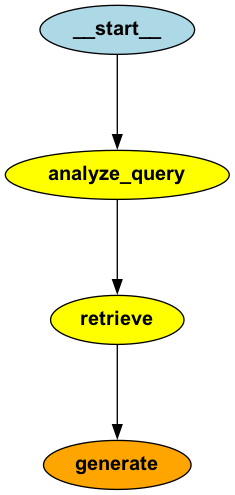

In [92]:
from IPython.display import Image

Image(graph.get_graph().draw_png())